In [104]:
from pathlib import Path
import numpy as np
import os
import sys
import pickle
from corsikaio import CorsikaParticleFile
# Define the file paths
zenith = 0 #degrees, available: 0 20 30 50 70 80 85 88
d_size = 1 #dot size 
E_mag = 6 # available: 1.00E6, 1.00E5, 1.00E4, 1.00E3, 1.00E1 GeV
particle = 6 #5 is mu+, 6 is mu-
production_height = "20.E5" # in cm,  available: 20.E5, 10.E5, 100.E5 
tele_radi = "150." #telescope radius in cm, available: 150. 15000.

#FOr large files, use the following code: 
# cd /uufs/chpc.utah.edu/common/home/u1520754/corsika-78010/src/utils/coast/dat2npy
# ./dat2npy DAT000101 output_file_name 
file1 = "/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_h20.E5_r150./out_sib23d-pId6-En1.00E5-20./OUTPUT_1.00E5_6_20._101/DAT000101.npy-0001.npy"
data = np.load(file1, allow_pickle=True)
#print("x  y  z  energy")
for pp in data:
    if abs(pp[0]) == 13:
        #print(pp[2], pp[3], pp[6], pp[5])
        pass

#For small files, use the following code
# File paths and directory setup

# Particle file reading and muon collection
def read_particle_file(file_path, particle_list):
    print("Reading event num:", file_path[-2]+file_path[-1])
    particles = []
    with CorsikaParticleFile(file_path, parse_blocks=False) as f:
        for event in f:
            i = 0
            print('Start reading particles')
            for pp in event.particles:
                particle_pid = np.abs(int(pp[0] // 1000))  # Determine particle ID
                if particle_pid in particle_list:  # Muon: 5 or 6, 
                    i += 1
                    print(i)
                    if particle_pid in [5, 6, 75, 76]:  # Muon reach the ground: 5 or 6, else 85 or 86
                        mass = 0.1056583745 #GeV
                    elif particle_pid == 1: #gamma 
                        mass = 0
                    elif particle_pid in [2, 3]: #electron (2) and positron (3)
                        mass = 0.000511 #GeV
                    elif particle_pid == 7: #pi0
                        mass = 0.1349766 #GeV
                    elif particle_pid in [8,9]: #pi+ and p-
                        mass = 0.13957015 #GeV
                    else:
                        print("Unknown particle ID:", particle_pid)
                        continue
                    energy = np.sqrt(mass**2 + pp[1]**2 + pp[2]**2 + pp[3]**2)
                    print("Particle ID", particle_pid)
                    print("  x", pp[4], "cm", "  y", pp[5], "cm")
                    print("  E", energy, "GeV","  t", pp[6], "s")
                    particles.append([particle_pid, pp[4], pp[5], pp[6], energy])
    return particles
ID = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] #event id
file2 = [
    f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_h{production_height}_r{tele_radi}/out_sib23d-pId{particle}-En1.00E{E_mag}-{zenith}./OUTPUT_1.00E{E_mag}_{particle}_{zenith}._{100+i}/DAT000{100+i}"
    for i in ID #event id
]
particles = read_particle_file(file2[4], [1, 2, 3, 4,5,6,7,8,9,75,76])

def count_repeats_numpy(arr):
    # Convert to numpy array
    arr = np.array(arr)
    
    # Get unique elements and counts
    unique, counts = np.unique(arr, return_counts=True)
    
    # Combine into readable format
    count_info = dict(zip(unique, counts))
    
    # Print all counts
    print("All elements:")
    for num, count in count_info.items():
        print(f"Number {num} appears {count} times")
    
    # Print only repeats
    print("\nOnly repeated elements:")
    for num, count in count_info.items():
        if count > 1:
            print(f"Number {num} repeats {count} times")

# Example usage
p_list = np.array([int(p[0]) for p in particles])
count_repeats_numpy(p_list)

Reading event num: 05
Start reading particles
1
Particle ID 76
  x -0.0 cm   y 0.0 cm
  E 1000000.0 GeV   t 11282920.0 s
2
Particle ID 6
  x 0.02373214 cm   y 5.2250204 cm
  E 996808.6 GeV   t 366537.56 s
3
Particle ID 1
  x -8352.975 cm   y -44632.79 cm
  E 0.037606664 GeV   t 366660.44 s
4
Particle ID 1
  x 4340.7744 cm   y -34717.957 cm
  E 0.021695422 GeV   t 366608.62 s
5
Particle ID 1
  x -4222.816 cm   y 2917.3257 cm
  E 0.016262893 GeV   t 366539.06 s
6
Particle ID 1
  x 1228.3201 cm   y 12993.178 cm
  E 0.038370214 GeV   t 366556.34 s
7
Particle ID 1
  x -14145.41 cm   y -29243.94 cm
  E 0.041582182 GeV   t 366649.8 s
8
Particle ID 1
  x 5270.3887 cm   y 9431.703 cm
  E 0.019730657 GeV   t 366549.5 s
9
Particle ID 1
  x -6813.311 cm   y 14228.636 cm
  E 0.039618917 GeV   t 366565.8 s
10
Particle ID 1
  x -20047.701 cm   y -9678.151 cm
  E 0.02302513 GeV   t 366649.06 s
11
Particle ID 1
  x -27813.871 cm   y 6098.2837 cm
  E 0.029897219 GeV   t 366586.78 s
12
Particle ID 1
  x 

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from eventio import IACTFile

def plot_photon_scatter(input_file, ax, event_index=0, telescope_id=None, theta=0, dot_size=1):
    """
    Plot the spatial distribution of Cherenkov photons from a CORSIKA simulation file on a given Axes.

    Parameters:
    -----------
    input_file : str
        Path to the CORSIKA telescope data file (.dat)
    ax : matplotlib.axes.Axes
        The Axes object to plot on
    event_index : int
        Index of the event to analyze (0-based)
    telescope_id : int or None
        ID of specific telescope to analyze, or None for all telescopes

    Returns:
    --------
    None
    """
    try:
        with IACTFile(input_file) as f:
            # Skip to the requested event
            events = iter(f)
            event = next(events)
            azimuth = (event.header['azimuth'])
            for _ in range(event_index):
                try:
                    event = next(events)
                except StopIteration:
                    print(f"Error: Event {event_index} not found in file {input_file}.")
                    return

            # Get telescope positions
            if telescope_id is not None:
                try:
                    photons = [event.photon_bunches[telescope_id]]
                    positions = [f.telescope_positions[telescope_id]]
                    
                except KeyError:
                    print(f"Error: Telescope {telescope_id} not found in event {event_index} of file {input_file}.")
                    return
            else:
                photons = list(event.photon_bunches.values())
                positions = f.telescope_positions

            # Plot photons from each telescope
            total_photons = 0
            for pos, tel_photons in zip(positions, photons):
                n_photons = len(tel_photons)
                total_photons += n_photons

                if n_photons > 0:
                    X = tel_photons['x'] + pos[0]
                    Y = tel_photons['y'] + pos[1]
                    #print(pos[0], pos[1])
                    #projection on shower coordinate:
                    azimuth = -azimuth
                    theta = np.radians(theta)
                    x_shower = (np.array(X)*np.cos(azimuth) - np.array(Y)*np.sin(azimuth))*np.cos(theta)
                    y_shower = np.array(X)*np.sin(azimuth) + np.array(Y)*np.cos(azimuth)
                    ax.scatter(
                        x=x_shower,
                        #x=tel_photons['x'] + pos[0],
                        y=y_shower,
                        #y=tel_photons['y'] + pos[1],
                        c='w',
                        s=dot_size,
                        alpha=0.7,
                        lw=0,
                    )

            ax.set_aspect(1)
            ax.set_facecolor('k')
            ax.set_xlabel('X position (cm)', fontsize=12, color='black')
            ax.set_ylabel('Y position (cm)', fontsize=12, color='black')
            ax.set_title(f'Event {event_index} - {total_photons} photons', fontsize=14, color='black')

            ax.tick_params(axis='x', colors='black', labelsize=10)
            ax.tick_params(axis='y', colors='black', labelsize=10)

            for spine in ax.spines.values():
                spine.set_edgecolor('black')

            ax.grid(True, alpha=0.2, color='gray', linestyle='--')

            if total_photons > 0:
                photon_positions = []
                for pos, tel_photons in zip(positions, photons):
                    if len(tel_photons) > 0:
                        photon_positions.append(np.column_stack([
                            tel_photons['x'] + pos[0],
                            tel_photons['y'] + pos[1]
                        ]))

                if photon_positions:
                    all_positions = np.vstack(photon_positions)
                    x_min, y_min = all_positions.min(axis=0)
                    x_max, y_max = all_positions.max(axis=0)

                    padding_x = 0.1 * (x_max - x_min)
                    padding_y = 0.1 * (y_max - y_min)
                    #ax.set_xlim(x_min - padding_x, x_max + padding_x)
                    #ax.set_ylim(y_min - padding_y, y_max + padding_y)
                    ax.set_xlim(-200, 200)
                    ax.set_ylim(-200, 200)

    except FileNotFoundError:
        print(f"Error: File '{input_file}' not found.")
    except Exception as e:
        print(f"Error processing file '{input_file}': {str(e)}")

def plot_4_events(input_files, particle, zenith, E_mag, production_height, tele_radi, d_size):
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    if particle == 6:
        particle_name = "mu-"
    elif particle == 5:
        particle_name = "mu+"
    fig.suptitle(f'Cherenkov Photon Distributions, particle: {particle_name}, zenith = {zenith} degree, energy = 1E{E_mag} GeV, production height = {production_height}cm, telescope radius = {tele_radi}cm', fontsize=16, color='black')

    # Flatten the 2D array of axes for easy iteration
    axs = axs.flatten()

    # Plot each file in a separate subplot
    for i, (input_file, ax) in enumerate(zip(input_files, axs)):
        plot_photon_scatter(input_file, ax, event_index=0, telescope_id=None, theta=zenith, dot_size=d_size)
        ax.set_title(f'Event {ID[i]}', fontsize=14, color='black')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
# Define the file paths
zenith = 80 #degrees, available: 0 20 30 50 70 80 85 88
d_size = 1
E_mag = 6 # available: 1.00E6, 1.00E5, 1.00E4, 1.00E3, 1.00E1 GeV
particle = 6 #5 is mu+, 6 is mu-
production_height = "20.E5" # in cm,  available: 20.E5, 10.E5, 100.E5 
tele_radi = "150." #telescope radius in cm, available: 150. 15000.

In [106]:
ID = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] #event id
file2 = [
    f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_h{production_height}_r{tele_radi}/out_sib23d-pId{particle}-En1.00E{E_mag}-{zenith}./OUTPUT_1.00E{E_mag}_{particle}_{zenith}._{100+i}/DAT000{100+i}"
    for i in ID #event id
]
particles = read_particle_file(file2[5], [5,6])

Reading event num: 06
Start reading particles
1
Particle ID 6
  x -170.67546 cm
  y 542.69415 cm
  t 1725721.8 s
  E 994663.0 GeV
2
Particle ID 6
  x 674059.06 cm
  y -675249.4 cm
  t 1694973.5 s
  E 3.5335 GeV
3
Particle ID 5
  x 185449.89 cm
  y -356673.84 cm
  t 1712790.8 s
  E 5.832499 GeV


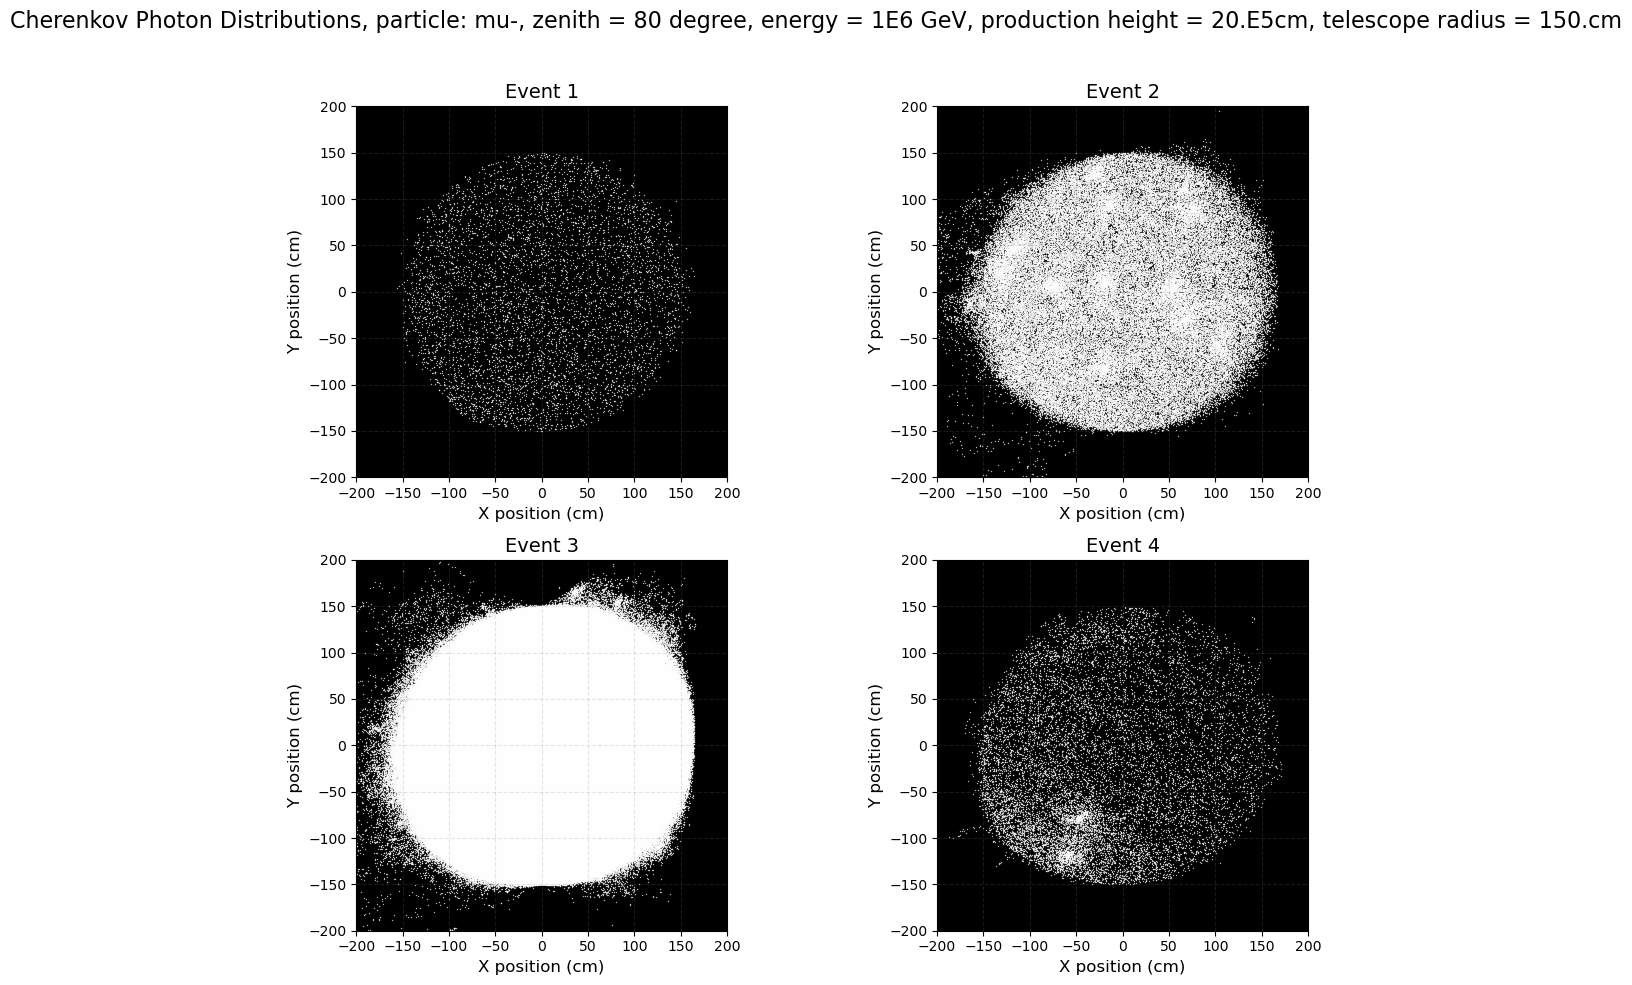

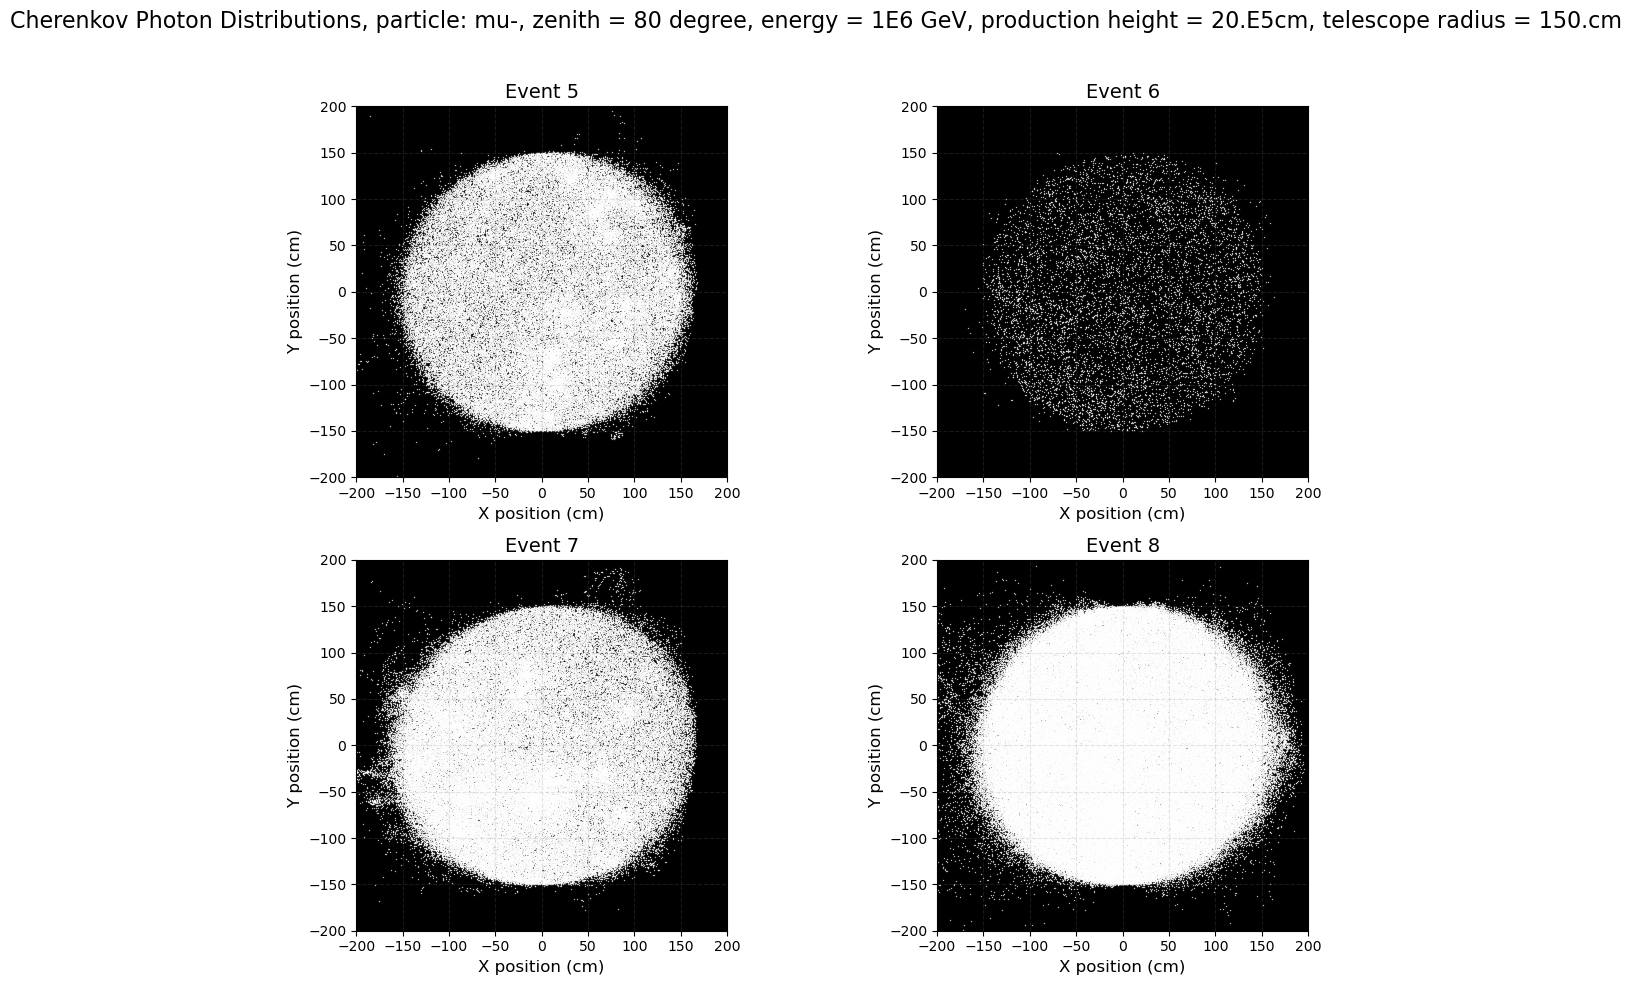

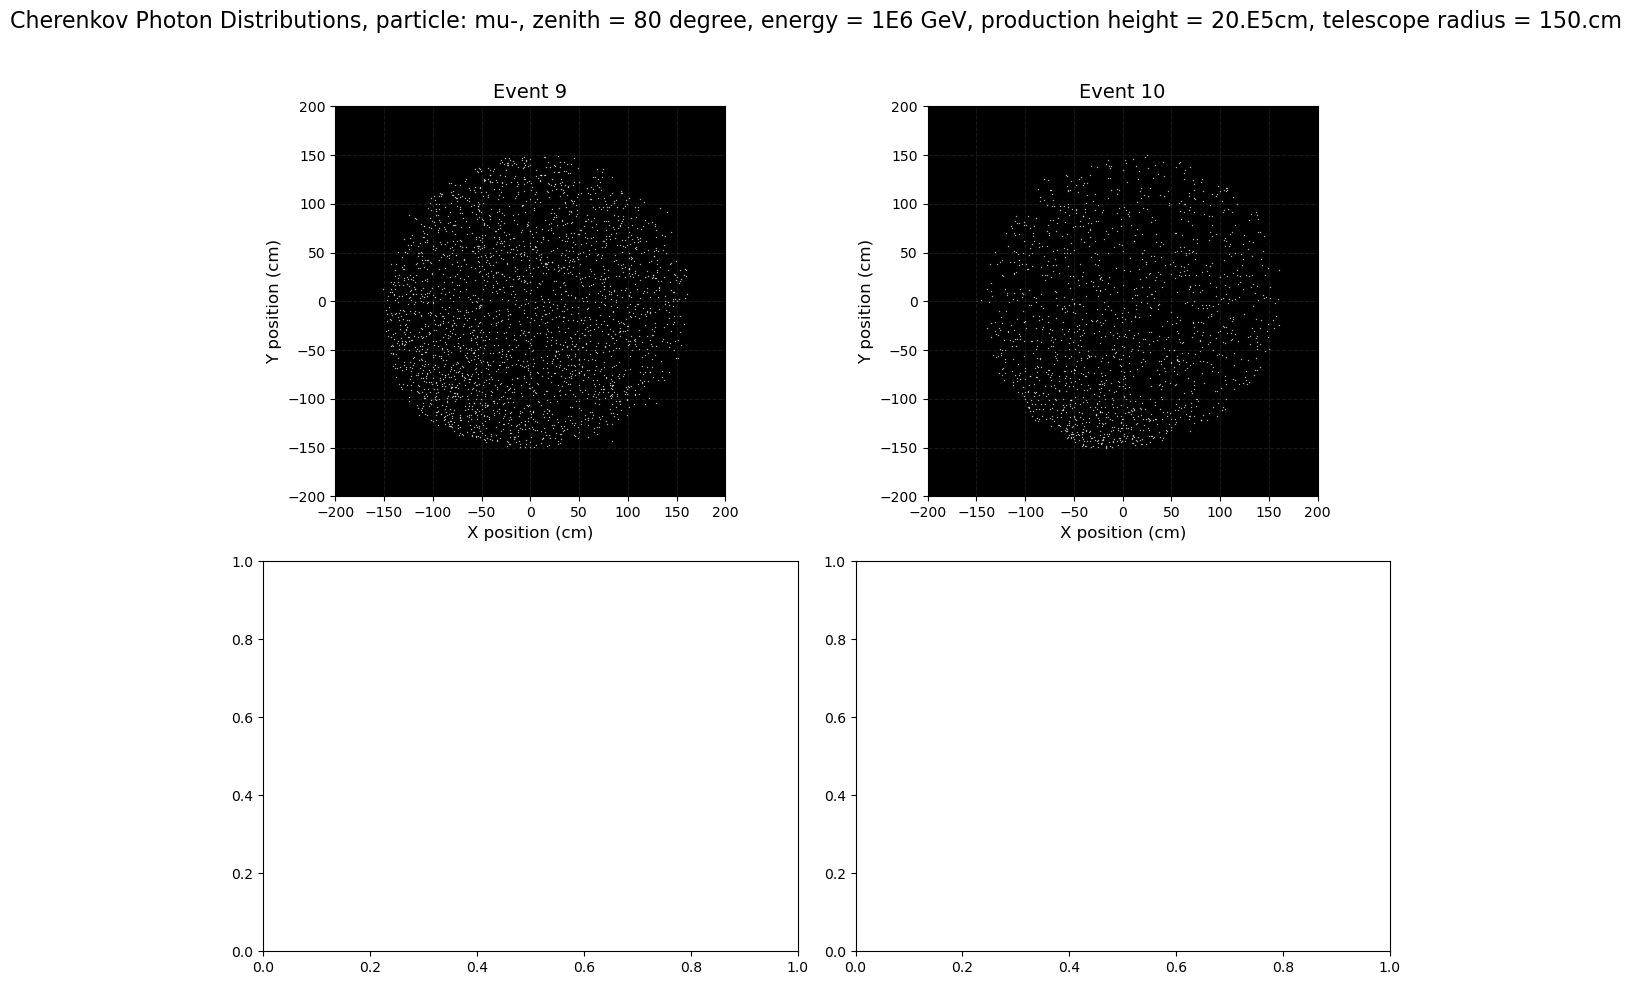

In [112]:
ID = [1, 2, 3, 4] 
input_files = [
    f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_h{production_height}_r{tele_radi}/out_sib23d-pId{particle}-En1.00E{E_mag}-{zenith}./OUTPUT_1.00E{E_mag}_{particle}_{zenith}._{100+i}/telescope.dat"
    for i in ID #event id
    ]
plot_4_events(input_files, particle, zenith, E_mag, production_height, tele_radi, d_size)
####
ID = [5, 6, 7, 8] 
input_files = [
    f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_h{production_height}_r{tele_radi}/out_sib23d-pId{particle}-En1.00E{E_mag}-{zenith}./OUTPUT_1.00E{E_mag}_{particle}_{zenith}._{100+i}/telescope.dat"
    for i in ID #event id
    ]
plot_4_events(input_files, particle, zenith, E_mag, production_height, tele_radi, d_size)
####
ID = [9, 10] 
input_files = [
    f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_h{production_height}_r{tele_radi}/out_sib23d-pId{particle}-En1.00E{E_mag}-{zenith}./OUTPUT_1.00E{E_mag}_{particle}_{zenith}._{100+i}/telescope.dat"
    for i in ID #event id
    ]
plot_4_events(input_files, particle, zenith, E_mag, production_height, tele_radi, d_size)


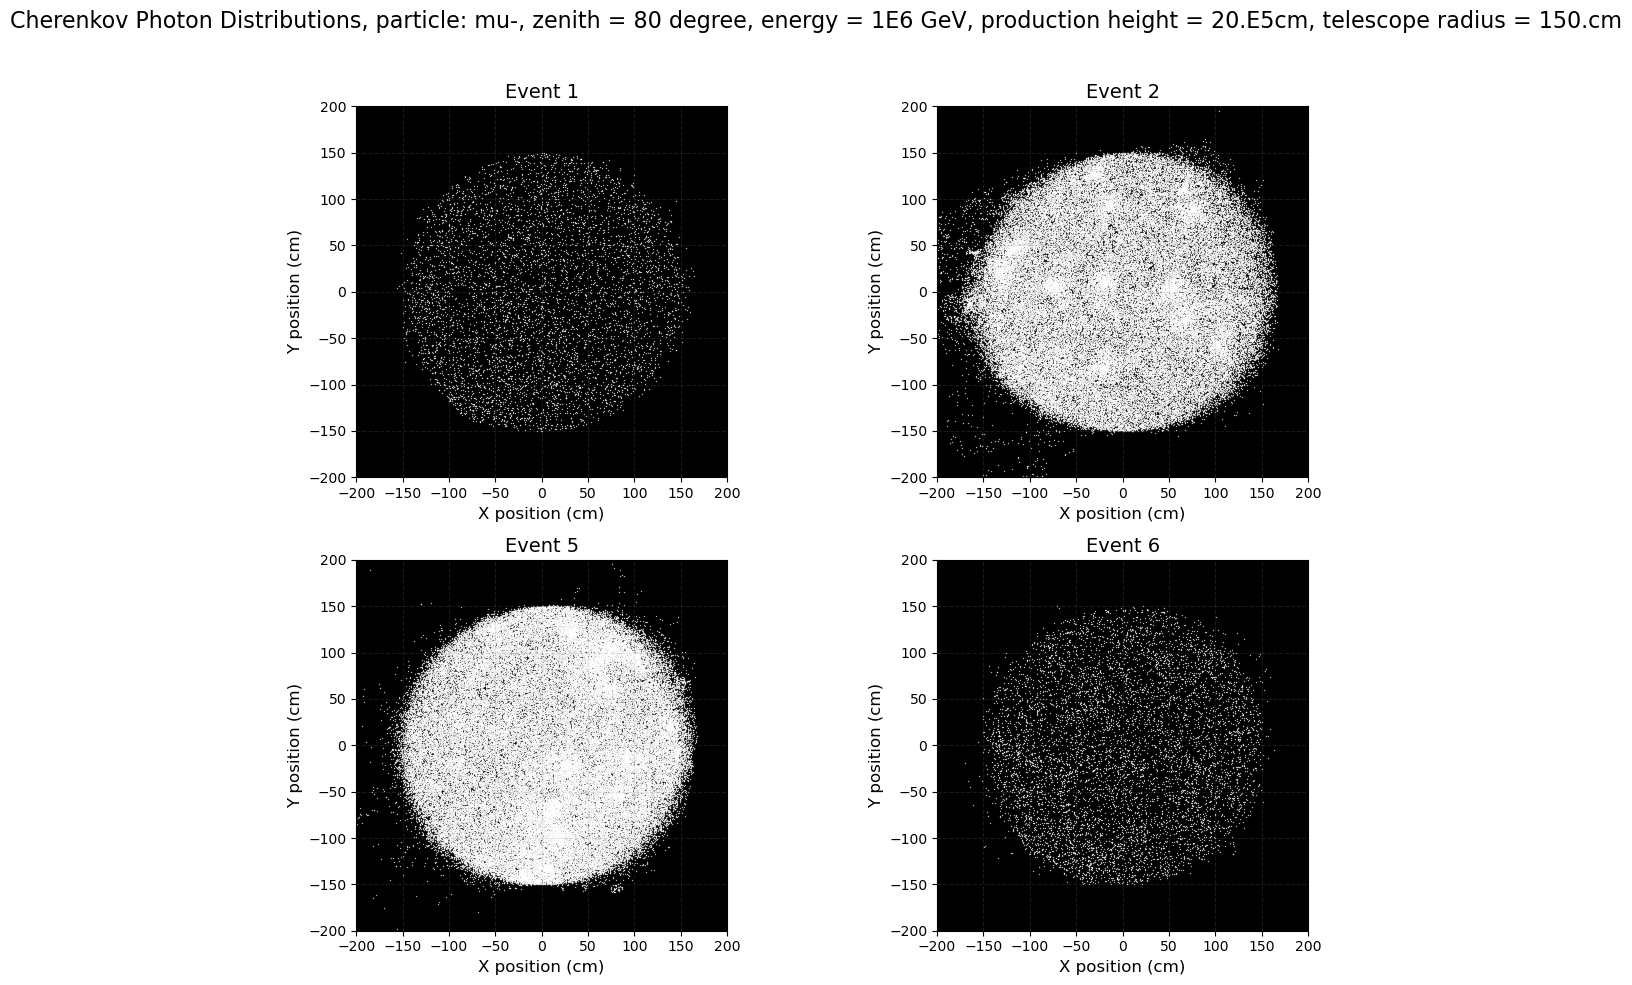

In [ ]:
ID = [1, 2, 5, 6] 

input_files = [
    f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_h{production_height}_r{tele_radi}/out_sib23d-pId{particle}-En1.00E{E_mag}-{zenith}./OUTPUT_1.00E{E_mag}_{particle}_{zenith}._{100+i}/telescope.dat"
    for i in ID #event id
]
plot_4_events(input_files, particle, zenith, E_mag, production_height, tele_radi, d_size)



In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from eventio import IACTFile
import scipy.stats as stats
import matplotlib
from corsikaio import CorsikaParticleFile

def count_repeats_numpy(arr):
    # Convert to numpy array
    arr = np.array(arr)
    
    # Get unique elements and counts
    unique, counts = np.unique(arr, return_counts=True)
    
    # Combine into readable format
    count_info = dict(zip(unique, counts))
    
    # Print all counts
    print("All elements:")
    for num, count in count_info.items():
        print(f"Number {num} appears {count} times")  

def read_particle_file(file_path, particle_list):
    #print("Reading event num:", file_path[-2]+file_path[-1])
    particles = []
    with CorsikaParticleFile(file_path, parse_blocks=False) as f:
        for event in f:
            i = 0
            #print('Start reading particles')
            for pp in event.particles:
                particle_pid = np.abs(int(pp[0] // 1000))  # Determine particle ID
                if particle_pid in particle_list:  # Muon: 5 or 6, 
                    i += 1
                    #print(i)
                    if particle_pid in [5, 6, 75, 76]:  # Muon reach the ground: 5 or 6, else 85 or 86
                        mass = 0.1056583745 #GeV
                    elif particle_pid == 1: #gamma 
                        mass = 0
                    elif particle_pid in [2, 3]: #electron (2) and positron (3)
                        mass = 0.000511 #GeV
                    elif particle_pid == 7: #pi0
                        mass = 0.1349766 #GeV
                    elif particle_pid in [8,9]: #pi+ and p-
                        mass = 0.13957015 #GeV
                    else:
                        print("Unknown particle ID:", particle_pid)
                        continue
                    energy = np.sqrt(mass**2 + pp[1]**2 + pp[2]**2 + pp[3]**2)
                    #print("Particle ID", particle_pid)
                    #print("  x", pp[4], "cm", "  y", pp[5], "cm")
                    #print("  E", energy, "GeV","  t", pp[6], "s")
                    particles.append([particle_pid, pp[4], pp[5], pp[6], energy])
    #p_list = np.array([int(p[0]) for p in particles])
    #count_repeats_numpy(p_list)
    return particles
def plot_photon_heatmap(input_file, particle_file, ax, event_index=0, telescope_id=None, theta=0, bins=500, tele_radi=150):
    """
    Plot the spatial distribution of Cherenkov photons as a heatmap with different particles.
    
    Parameters:
    -----------
    input_file : str
        Path to the CORSIKA telescope data file (.dat)
    particle_file : str
        Path to the CORSIKA particle file to get particle positions
    ax : matplotlib.axes.Axes
        The Axes object to plot on
    event_index : int
        Index of the event to analyze (0-based)
    telescope_id : int or None
        ID of specific telescope to analyze, or None for all telescopes
    theta : float
        Zenith angle in degrees
    bins : int or tuple
        Number of bins for histogram (resolution of heatmap)
    tele_radi : float
        Telescope radius in cm
    """
    try:
        # First read particle data - include all particle types of interest
        particles = read_particle_file(
            particle_file, 
            [1, 2, 3, 5, 6, 7, 8, 9, 75, 76]  # All particle types we want to visualize
        )
        
        # Process photon data as before
        with IACTFile(input_file) as f:
            events = iter(f)
            event = next(events)
            azimuth = (event.header['azimuth'])
            
            # Skip to requested event
            for _ in range(event_index):
                try:
                    event = next(events)
                except StopIteration:
                    print(f"Error: Event {event_index} not found in file {input_file}.")
                    return

            # Get telescope positions and photons
            if telescope_id is not None:
                try:
                    photons = [event.photon_bunches[telescope_id]]
                    positions = [f.telescope_positions[telescope_id]]
                except KeyError:
                    print(f"Error: Telescope {telescope_id} not found in event {event_index}.")
                    return
            else:
                photons = list(event.photon_bunches.values())
                positions = f.telescope_positions

            # Collect all photon positions
            all_x_shower = []
            all_y_shower = []
            
            total_photons = 0
            for pos, tel_photons in zip(positions, photons):
                n_photons = len(tel_photons)
                total_photons += n_photons

                if n_photons > 0:
                    X = tel_photons['x'] + pos[0]
                    Y = tel_photons['y'] + pos[1]
                    
                    # Project onto shower coordinate system
                    azimuth_rad = -azimuth
                    theta_rad = np.radians(theta)
                    x_shower = (np.array(X)*np.cos(azimuth_rad) - np.array(Y)*np.sin(azimuth_rad))*np.cos(theta_rad)
                    y_shower = np.array(X)*np.sin(azimuth_rad) + np.array(Y)*np.cos(azimuth_rad)
                    
                    all_x_shower.extend(x_shower)
                    all_y_shower.extend(y_shower)

            # Create the heatmap using histogram2d
            if total_photons > 0:
                # Define the bins
                x_range = (-tele_radi*1.2, tele_radi*1.2)
                y_range = (-tele_radi*1.2, tele_radi*1.2)
                
                # Create 2D histogram
                heatmap, xedges, yedges = np.histogram2d(
                    all_x_shower, 
                    all_y_shower, 
                    bins=bins, 
                    range=[x_range, y_range]
                )
                
                # Create the heatmap plot - using LogNorm for better visualization
                im = ax.imshow(
                    heatmap.T,  # Transpose for correct orientation
                    origin='lower',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    aspect='auto',
                    cmap='plasma',  # Good colormaps: 'viridis', 'plasma', 'inferno'
                    norm=LogNorm(vmin=1, vmax=heatmap.max())  # Log scale for better visibility
                )
                
                # Add colorbar
                cbar = plt.colorbar(im, ax=ax)
                cbar.set_label('Log10(Photon Density)', rotation=270, labelpad=15, fontsize=12, color='white')
                
                # Option 2: Logarithmic scale ticks (if using LogNorm)
                vmin, vmax = im.norm.vmin, im.norm.vmax
                # Use 10^n format for better readability with logarithmic scale
                log_ticks = np.logspace(np.log10(vmin), np.log10(vmax), 5)
                cbar.set_ticks(log_ticks)
                # Format as 10^n notation
                cbar.set_ticklabels([f'${{{np.round(np.log10(t),2)}}}$' for t in log_ticks])
                plt.setp(cbar.ax.get_yticklabels(), color='white', fontsize=17)

                # Add contour lines to highlight structure (optional)
                contour_levels = np.logspace(0, np.log10(heatmap.max()), 5)
                ax.contour(
                    heatmap.T, 
                    levels=contour_levels,
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    colors='white',
                    alpha=0.3,
                    linewidths=0.5
                )
                
                # Define particle visualization settings
                particle_settings = {
                    1: {'marker': 'o', 'color': 'white', 'label': 'Gamma', 'size_scale': 100, 'alpha': 0.7},  # gamma
                    2: {'marker': '^', 'color': 'white', 'label': 'Electron', 'size_scale': 100, 'alpha': 0.9},  # electron
                    3: {'marker': '^', 'color': 'yellow', 'label': 'Positron', 'size_scale': 100, 'alpha': 0.9},  # positron
                    5: {'marker': 's', 'color': 'white', 'label': 'μ+', 'size_scale': 100, 'alpha': 0.9},  # mu+
                    6: {'marker': 's', 'color': 'yellow', 'label': 'μ-', 'size_scale': 100, 'alpha': 0.9},  # mu-
                    7: {'marker': '*', 'color': 'white', 'label': 'π0', 'size_scale': 100, 'alpha': 0.9},  # pi0
                    8: {'marker': 'h', 'color': 'white', 'label': 'π+', 'size_scale': 100, 'alpha': 0.9},  # pi+
                    9: {'marker': 'h', 'color': 'yellow', 'label': 'π-', 'size_scale': 100, 'alpha': 0.9},  # pi-
                    75: {'marker': 'D', 'color': 'white', 'label': 'μ+ (decay)', 'size_scale': 100, 'alpha': 0.9},  # mu+ decay
                    76: {'marker': 'D', 'color': 'yellow', 'label': 'μ- (decay)', 'size_scale': 100, 'alpha': 0.9},  # mu- decay
                }
                
                # Group particles by type
                particle_groups = {}
                for p in particles:
                    pid = p[0]
                    if pid not in particle_groups:
                        particle_groups[pid] = []
                    particle_groups[pid].append(p)
                
                # Plot each particle type with proper transformation
                legend_handles = []
                particle_counts = {}
                
                for pid, particle_list in particle_groups.items():
                    if pid in particle_settings:
                        settings = particle_settings[pid]
                        
                        # Prepare arrays for this particle type
                        p_x = []
                        p_y = []
                        p_energy = []
                        
                        # Apply coordinate transformation
                        for p in particle_list:
                            # Extract raw coordinates
                            raw_x = p[1]  # x position
                            raw_y = p[2]  # y position
                            energy = p[4]  # energy
                            
                            # Apply the same transformation as for photons
                            azimuth_rad = -azimuth
                            theta_rad = np.radians(theta)
                            x_transformed = (raw_x*np.cos(azimuth_rad) - raw_y*np.sin(azimuth_rad))*np.cos(theta_rad)
                            y_transformed = raw_x*np.sin(azimuth_rad) + raw_y*np.cos(azimuth_rad)
                            
                            # Check if particle is within plot range
                            if (x_range[0] <= x_transformed <= x_range[1]) and (y_range[0] <= y_transformed <= y_range[1]):
                                p_x.append(x_transformed)
                                p_y.append(y_transformed)
                                p_energy.append(energy)
                        
                        # Count visible particles
                        particle_counts[pid] = len(p_x)
                        
                        # Plot particles if any are visible
                        if p_x:
                            # Calculate sizes based on energy
                            #sizes = np.array(p_energy) * settings['size_scale']
                            sizes = settings['size_scale']
                            # Plot particle positions
                            scatter = ax.scatter(
                                p_x, p_y,
                                s=sizes,
                                c=settings['color'],
                                marker=settings['marker'],
                                alpha=settings['alpha'],
                                label=f"{settings['label']} ({len(p_x)})",
                                edgecolors='black' ,
                                linewidths=1
                            )
                            legend_handles.append(scatter)
                
                # Add legend only if particles were plotted
                if legend_handles:
                    ax.legend(
                        handles=legend_handles,
                        loc='upper right',
                        fontsize=8,
                        framealpha=0.7,
                        facecolor='black',
                        edgecolor='white',
                        labelcolor='white'
                    )
                
                # Format the plot
                ax.set_facecolor('black')
                ax.set_aspect('equal')
                ax.set_xlim(x_range)
                ax.set_ylim(y_range)
                
                # Add labels
                ax.set_xlabel('X position (cm)', fontsize=12, color='white')
                ax.set_ylabel('Y position (cm)', fontsize=12, color='white')
                
                # Update title to include total particles
                total_particles = sum(particle_counts.values()) if particle_counts else 0
                ax.set_title(f'Photons: {total_photons:,}  |  Particles: {total_particles:,}', 
                             fontsize=14, color='white')

                # Set ticks and grid properties
                ax.tick_params(axis='both', colors='white', labelsize=10)
                ax.grid(True, alpha=0.2, color='white', linestyle='--')
                
                # Set spines color
                for spine in ax.spines.values():
                    spine.set_edgecolor('white')
            else:
                ax.text(0.5, 0.5, 'No photons detected', 
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        color='white', fontsize=14)
                ax.set_facecolor('black')
                
    except FileNotFoundError:
        print(f"Error: File '{input_file}' or '{particle_file}' not found.")
    except Exception as e:
        print(f"Error processing files: {str(e)}")
        import traceback
        traceback.print_exc()

def plot_4_events_with_ground_particles(ID, particle, zenith, E_mag, production_height, tele_radi, num_bins=500):
    # Create a 2x2 grid of subplots
    input_files = [
        f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_h{production_height}_r{tele_radi}./out_sib23d-pId{particle}-En1.00E{E_mag}-{zenith}./OUTPUT_1.00E{E_mag}_{particle}_{zenith}._{100+i}/telescope.dat"
        for i in ID
    ]
    
    particle_files = [
        f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_h{production_height}_r{tele_radi}./out_sib23d-pId{particle}-En1.00E{E_mag}-{zenith}./OUTPUT_1.00E{E_mag}_{particle}_{zenith}._{100+i}/DAT000{100+i}"
        for i in ID
    ]
    
    fig, axs = plt.subplots(2, 2, figsize=(14, 12), facecolor='black')
    
    # Set figure background to black for better visualization
    fig.patch.set_facecolor('black')
    
    # Determine particle name
    if particle == 6:
        particle_name = "μ⁻"
    elif particle == 5:
        particle_name = "μ⁺"
        
    # Set title with white text on black background
    title = f'Cherenkov Photon Density Map with Ground Particles\nPrimary: {particle_name}, θ = {zenith}°, E = 10^{E_mag} GeV, h = {production_height} cm, r = {tele_radi} cm'
    fig.suptitle(title, fontsize=16, color='white', y=0.98)

    # Flatten the 2D array of axes for easy iteration
    axs = axs.flatten()

    # Plot each file in a separate subplot
    for i, (input_file, particle_file, ax) in enumerate(zip(input_files, particle_files, axs)):
        plot_photon_heatmap(
            input_file, 
            particle_file, 
            ax, 
            event_index=0, 
            telescope_id=None, 
            theta=zenith, 
            bins=num_bins, 
            tele_radi=int(float(tele_radi))*1.1
        )
        ax.set_title(f'Event {ID[i]}', fontsize=14, color='white')

    # Adjust layout with more space for title
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    # Add description at the bottom of the figure
    fig.text(
        0.5, 0.01, 
        "",
        ha='center', 
        color='white', 
        fontsize=12
    )
    
    # Save the figure with high resolution
    plt.savefig(
        f'photon_heatmap_with_particles_z{zenith}_1E{E_mag}_p{particle}_h{production_height}_r{tele_radi}.png', 
        dpi=300, 
        bbox_inches='tight', 
        facecolor='black'
    )
    plt.show()


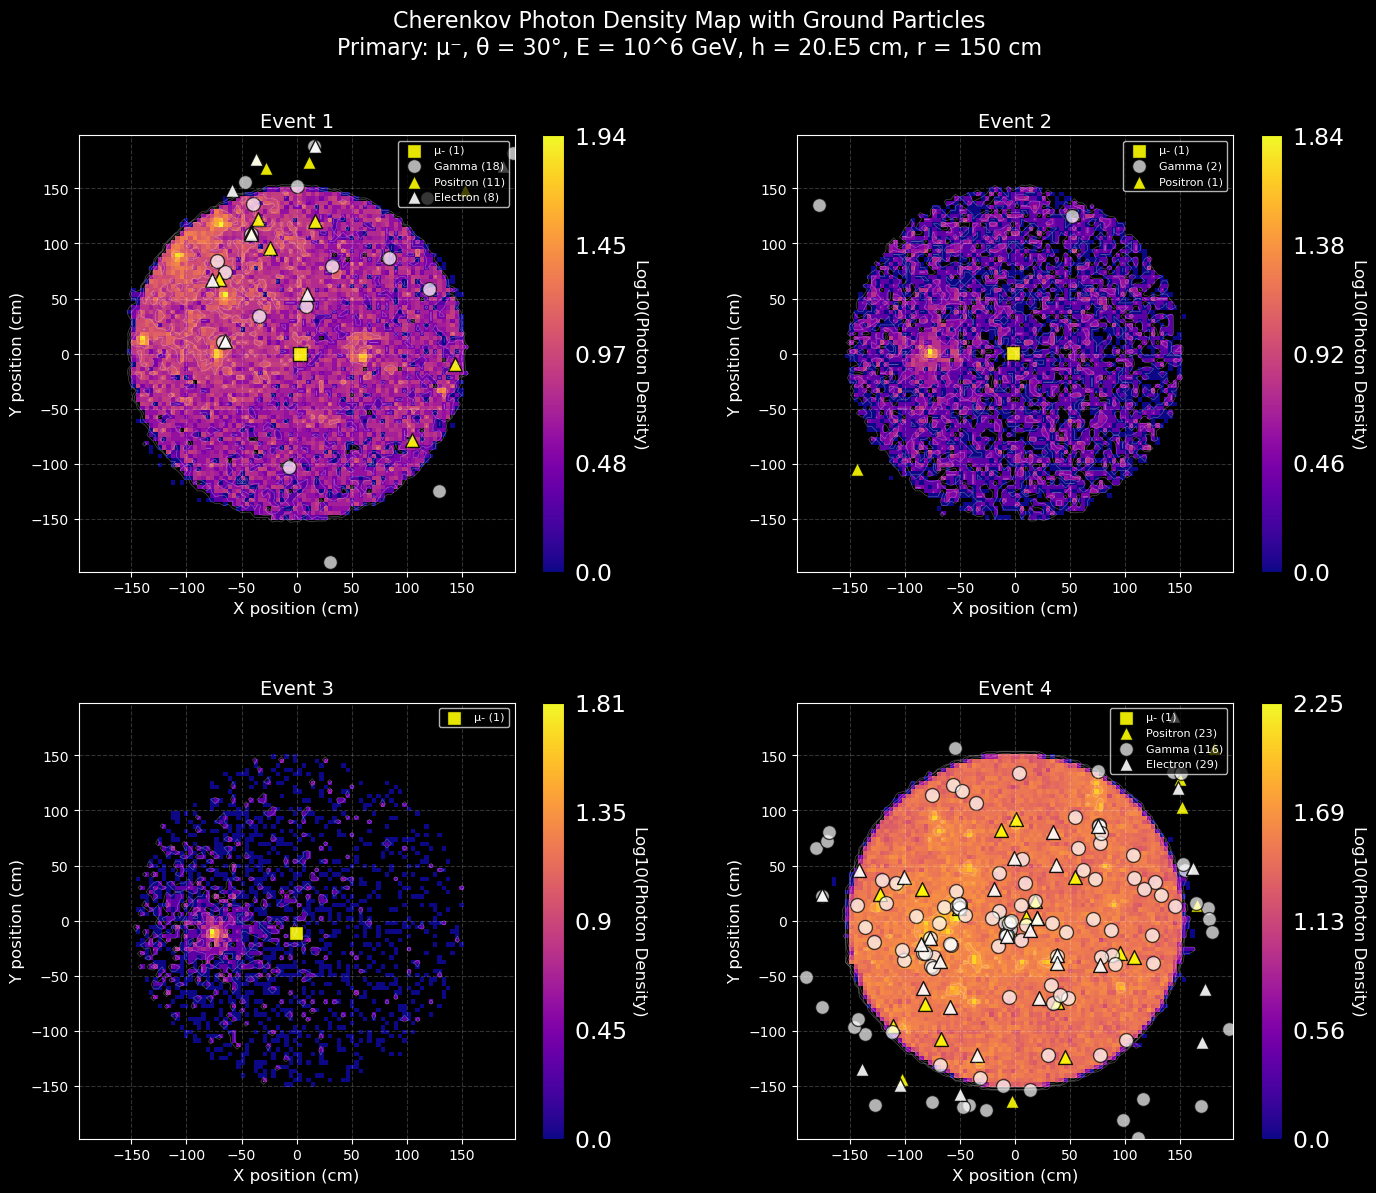

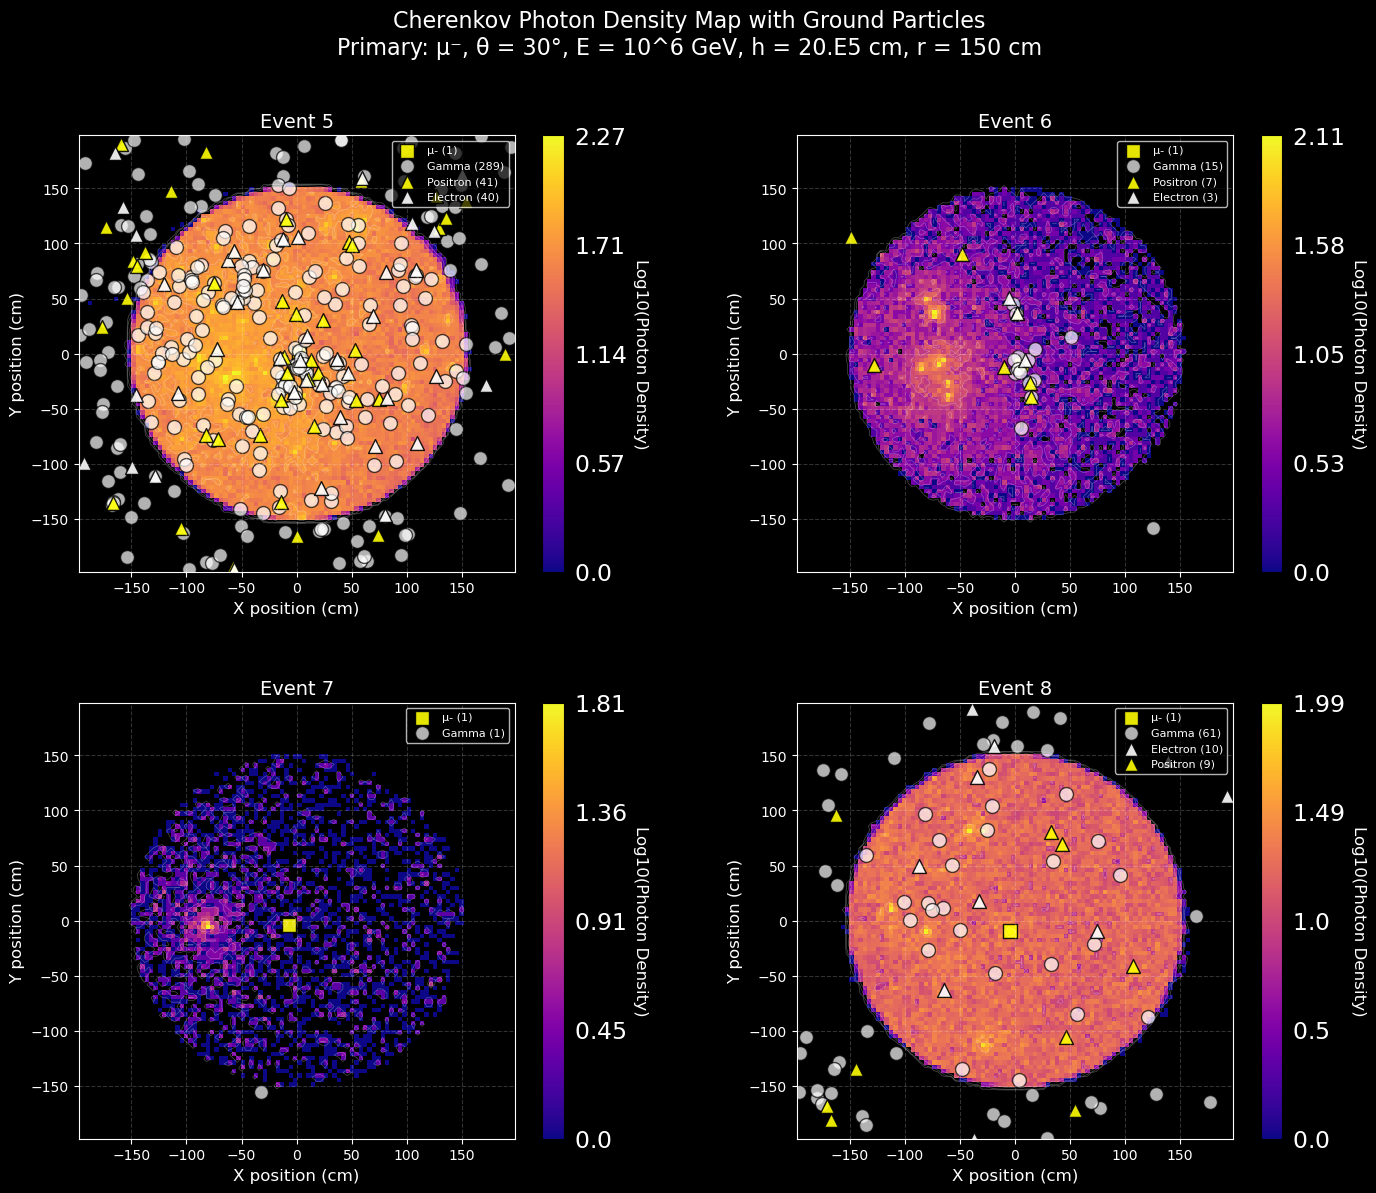

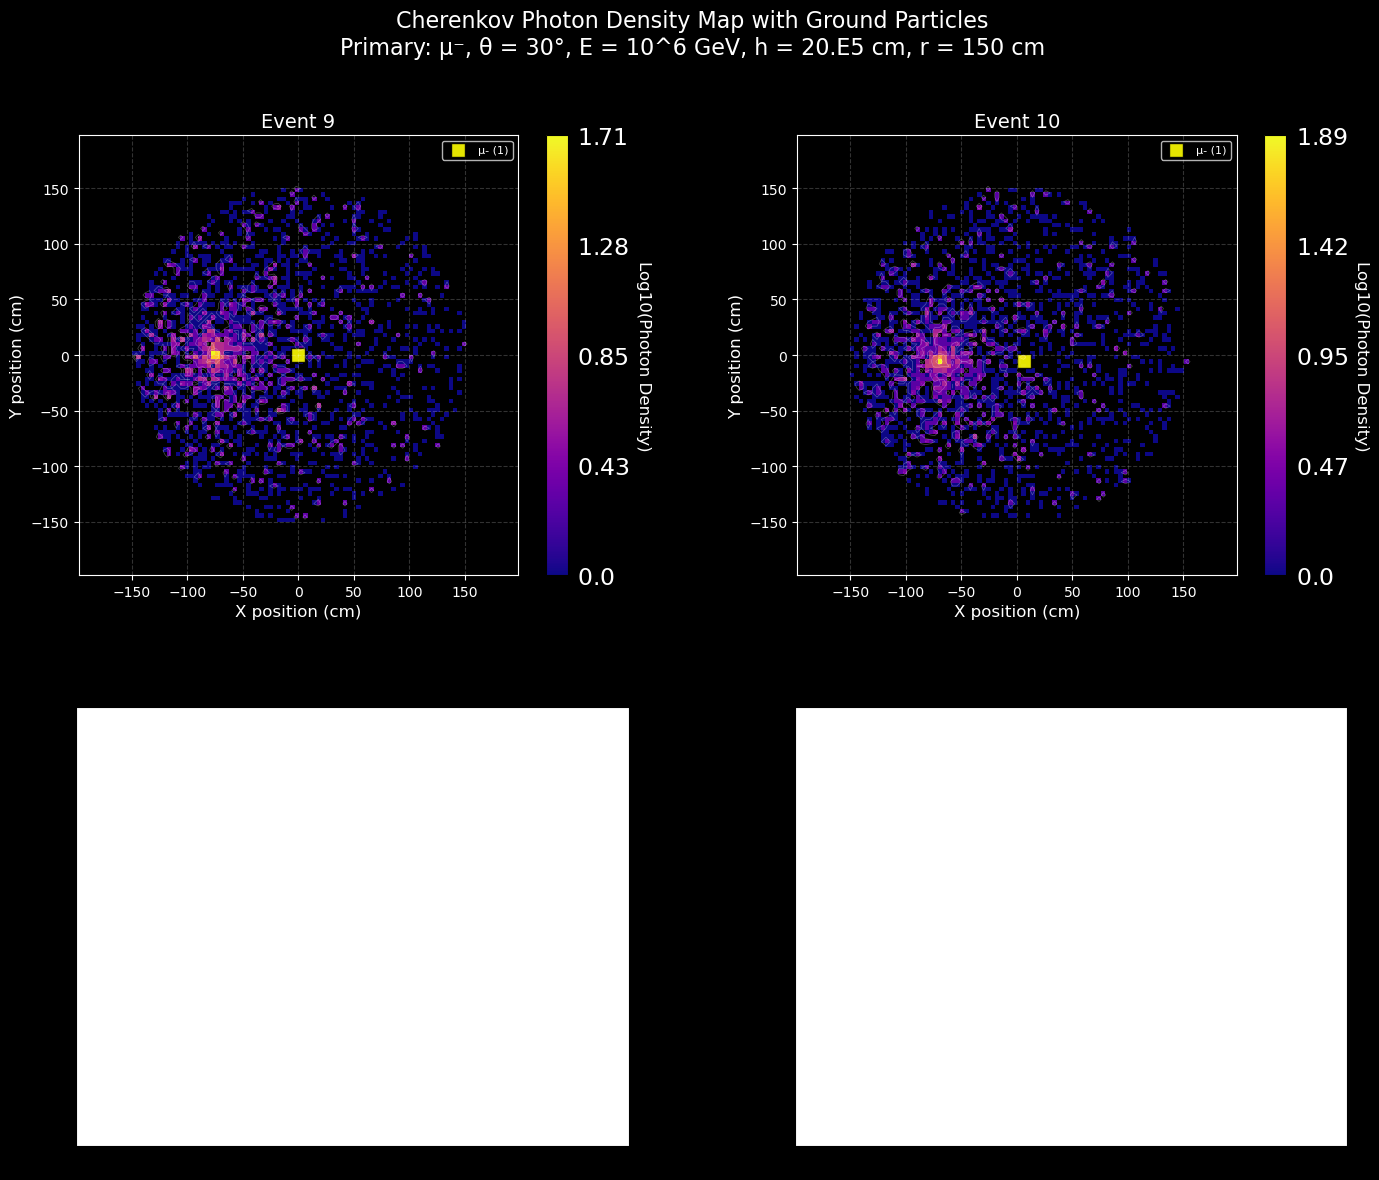

In [ ]:

# Define the parameters
zenith = 0  #  available: 0 30 60 88 degrees
E_mag = 6  # available: 1.00E6, 1.00E5, 1.00E4, 1.00E3, 1.00E2, 1.00E1 GeV
particle = 6  # 5 is mu+, 6 is mu-
production_height = "20.E5"  # available: 10.E5 20.E5 cm
tele_radi = "150"  # telescope radius in cm, available:  1500 15000
ID1 = [1, 2, 3, 4] 
ID2 = [5,6,7,8]
ID3 = [9,10]
# Create the plot
plot_4_events_with_ground_particles(ID1, particle, zenith, E_mag, production_height, tele_radi, num_bins=100)
plot_4_events_with_ground_particles(ID2, particle, zenith, E_mag, production_height, tele_radi, num_bins=100)
plot_4_events_with_ground_particles(ID3, particle, zenith, E_mag, production_height, tele_radi, num_bins=100)


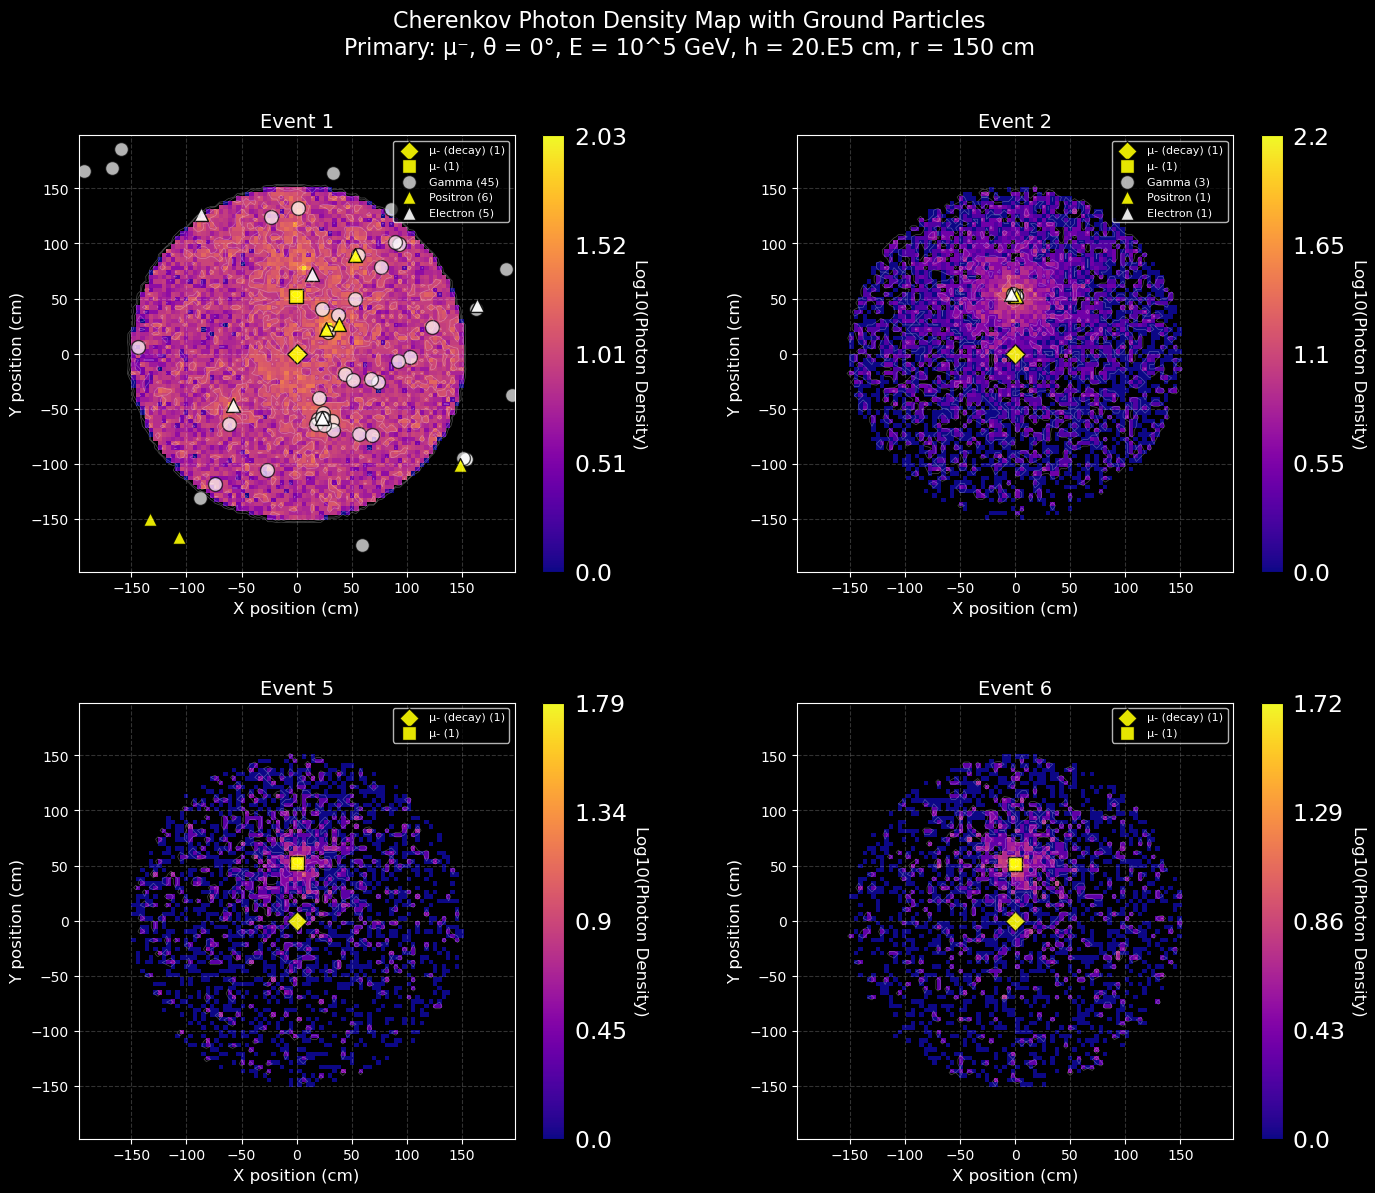

In [63]:
ID4 = [1,2,5,6]
plot_4_events_with_ground_particles(ID4, particle, zenith, E_mag, production_height, tele_radi, num_bins=100)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from eventio import IACTFile
import scipy.stats as stats
import matplotlib
def plot_photon_heatmap(input_file, ax, event_index=0, telescope_id=None, theta=0, bins=500, tele_radi=150):
    """
    Plot the spatial distribution of Cherenkov photons as a heatmap.

    Parameters:
    -----------
    input_file : str
        Path to the CORSIKA telescope data file (.dat)
    ax : matplotlib.axes.Axes
        The Axes object to plot on
    event_index : int
        Index of the event to analyze (0-based)
    telescope_id : int or None
        ID of specific telescope to analyze, or None for all telescopes
    theta : float
        Zenith angle in degrees
    bins : int or tuple
        Number of bins for histogram (resolution of heatmap)
    """
    try:
        with IACTFile(input_file) as f:
            # Skip to the requested event
            events = iter(f)
            event = next(events)
            azimuth = (event.header['azimuth'])
            for _ in range(event_index):
                try:
                    event = next(events)
                except StopIteration:
                    print(f"Error: Event {event_index} not found in file {input_file}.")
                    return

            # Get telescope positions and photons
            if telescope_id is not None:
                try:
                    photons = [event.photon_bunches[telescope_id]]
                    positions = [f.telescope_positions[telescope_id]]
                except KeyError:
                    print(f"Error: Telescope {telescope_id} not found in event {event_index}.")
                    return
            else:
                photons = list(event.photon_bunches.values())
                positions = f.telescope_positions

            # Collect all photon positions
            all_x_shower = []
            all_y_shower = []
            
            total_photons = 0
            for pos, tel_photons in zip(positions, photons):
                n_photons = len(tel_photons)
                total_photons += n_photons

                if n_photons > 0:
                    X = tel_photons['x'] + pos[0]
                    Y = tel_photons['y'] + pos[1]
                    
                    # Project onto shower coordinate system
                    azimuth_rad = -azimuth
                    theta_rad = np.radians(theta)
                    x_shower = (np.array(X)*np.cos(azimuth_rad) - np.array(Y)*np.sin(azimuth_rad))*np.cos(theta_rad)
                    y_shower = np.array(X)*np.sin(azimuth_rad) + np.array(Y)*np.cos(azimuth_rad)
                    
                    all_x_shower.extend(x_shower)
                    all_y_shower.extend(y_shower)

            # Create the heatmap using histogram2d
            if total_photons > 0:
                # Define the bins
                x_range = (-tele_radi*1.2, tele_radi*1.2)
                y_range = (-tele_radi*1.2, tele_radi*1.2)
                
                # Create 2D histogram
                heatmap, xedges, yedges = np.histogram2d(
                    all_x_shower, 
                    all_y_shower, 
                    bins=bins, 
                    range=[x_range, y_range]
                )
                
                # Apply Gaussian kernel smoothing (optional)
                # heatmap = stats.gaussian_kde(
                #     np.vstack([all_x_shower, all_y_shower])
                # )(np.mgrid[x_range[0]:x_range[1]:100j, y_range[0]:y_range[1]:100j].reshape(2, -1))
                
                # Create the heatmap plot - using LogNorm for better visualization
                im = ax.imshow(
                    heatmap.T,  # Transpose for correct orientation
                    origin='lower',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    aspect='auto',
                    cmap='plasma',  # Good colormaps: 'viridis', 'plasma', 'inferno'
                    norm=LogNorm(vmin=1, vmax=heatmap.max())  # Log scale for better visibility
                )
                
                # Add colorbar
                cbar = plt.colorbar(im, ax=ax)
                cbar.set_label('Log10(Photon Density)', rotation=270, labelpad=15, fontsize=12, color='white')


                # Option 2: Logarithmic scale ticks (if using LogNorm)
                
                    # Create logarithmically spaced ticks
                vmin, vmax = im.norm.vmin, im.norm.vmax
                    # Use 10^n format for better readability with logarithmic scale
                log_ticks = np.logspace(np.log10(vmin), np.log10(vmax), 5)
                cbar.set_ticks(log_ticks)
                    # Format as 10^n notation
                cbar.set_ticklabels([f'${{{np.round(np.log10(t),2)}}}$' for t in log_ticks])

                # Style all text elements in the colorbar
                #cbar.ax.tick_params(axis='both', colors='white', which='both')
                plt.setp(cbar.ax.get_yticklabels(), color='white', fontsize=17)

                # Style the colorbar frame
                #for spine in cbar.ax.spines.values():
                    #spine.set_edgecolor('white')
                # Add contour lines to highlight structure (optional)
                contour_levels = np.logspace(0, np.log10(heatmap.max()), 5)
                ax.contour(
                    heatmap.T, 
                    levels=contour_levels,
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    colors='white',
                    alpha=0.3,
                    linewidths=0.5
                )
                
                # Format the plot
                ax.set_facecolor('black')
                ax.set_aspect('equal')
                ax.set_xlim(x_range)
                ax.set_ylim(y_range)
                
                # Add labels and title
                ax.set_xlabel('X position (cm)', fontsize=12, color='white')
                ax.set_ylabel('Y position (cm)', fontsize=12, color='white')
                ax.set_title(f'Total: {total_photons} photons', fontsize=14, color='white')

                # Set ticks and grid properties
                ax.tick_params(axis='both', colors='white', labelsize=10)
                ax.grid(True, alpha=0.2, color='white', linestyle='--')
                
                # Set spines color
                for spine in ax.spines.values():
                    spine.set_edgecolor('white')
            else:
                ax.text(0.5, 0.5, 'No photons detected', 
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        color='white', fontsize=14)
                ax.set_facecolor('black')
                
    except FileNotFoundError:
        print(f"Error: File '{input_file}' not found.")
    except Exception as e:
        print(f"Error processing file '{input_file}': {str(e)}")
        import traceback
        traceback.print_exc()

def plot_4_events(input_files, particle, zenith, E_mag, production_height, tele_radi, num_bins=500):

    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 12), facecolor='black')
    
    # Set figure background to black for better visualization
    fig.patch.set_facecolor('black')
    
    # Determine particle name
    if particle == 6:
        particle_name = "μ⁻"
    elif particle == 5:
        particle_name = "μ⁺"
        
    # Set title with white text on black background
    title = f'Cherenkov Photon Density Map\nParticle: {particle_name}, θ = {zenith}°, E = 10^{E_mag} GeV, h = {production_height} cm, r = {tele_radi} cm'
    fig.suptitle(title, fontsize=16, color='white', y=0.98)

    # Flatten the 2D array of axes for easy iteration
    axs = axs.flatten()

    # Plot each file in a separate subplot
    for i, (input_file, ax) in enumerate(zip(input_files, axs)):
        # Higher resolution for better heatmap (adjust bins as needed)
        plot_photon_heatmap(input_file, ax, event_index=0, telescope_id=None, 
                            theta=zenith, bins=num_bins, tele_radi=int(tele_radi)*1.1)
        ax.set_title(f'Event {ID[i]}', fontsize=14, color='white')

    # Adjust layout with more space for title
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    # Save the figure with high resolution
    plt.savefig(f'photon_heatmap_z{zenith}_1E{E_mag}_p{particle}_h{production_height}_r{tele_radi}.png', 
                dpi=300, bbox_inches='tight', facecolor='black')
    plt.show()


/uufs/chpc.utah.edu/common/home/u1520754/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/corsikaio/subblocks/run_header.py:82: UserWarning: Version unknown, using run header definition dtype of version 7.x
  warnings.warn("Version unknown, using run header definition dtype of version 7.x")
/uufs/chpc.utah.edu/common/home/u1520754/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/corsikaio/subblocks/event_header.py:138: UserWarning: Version unknown, using event header dtype definition of version 7.7XXX
  warnings.warn("Version unknown, using event header dtype definition of version 7.7XXX")


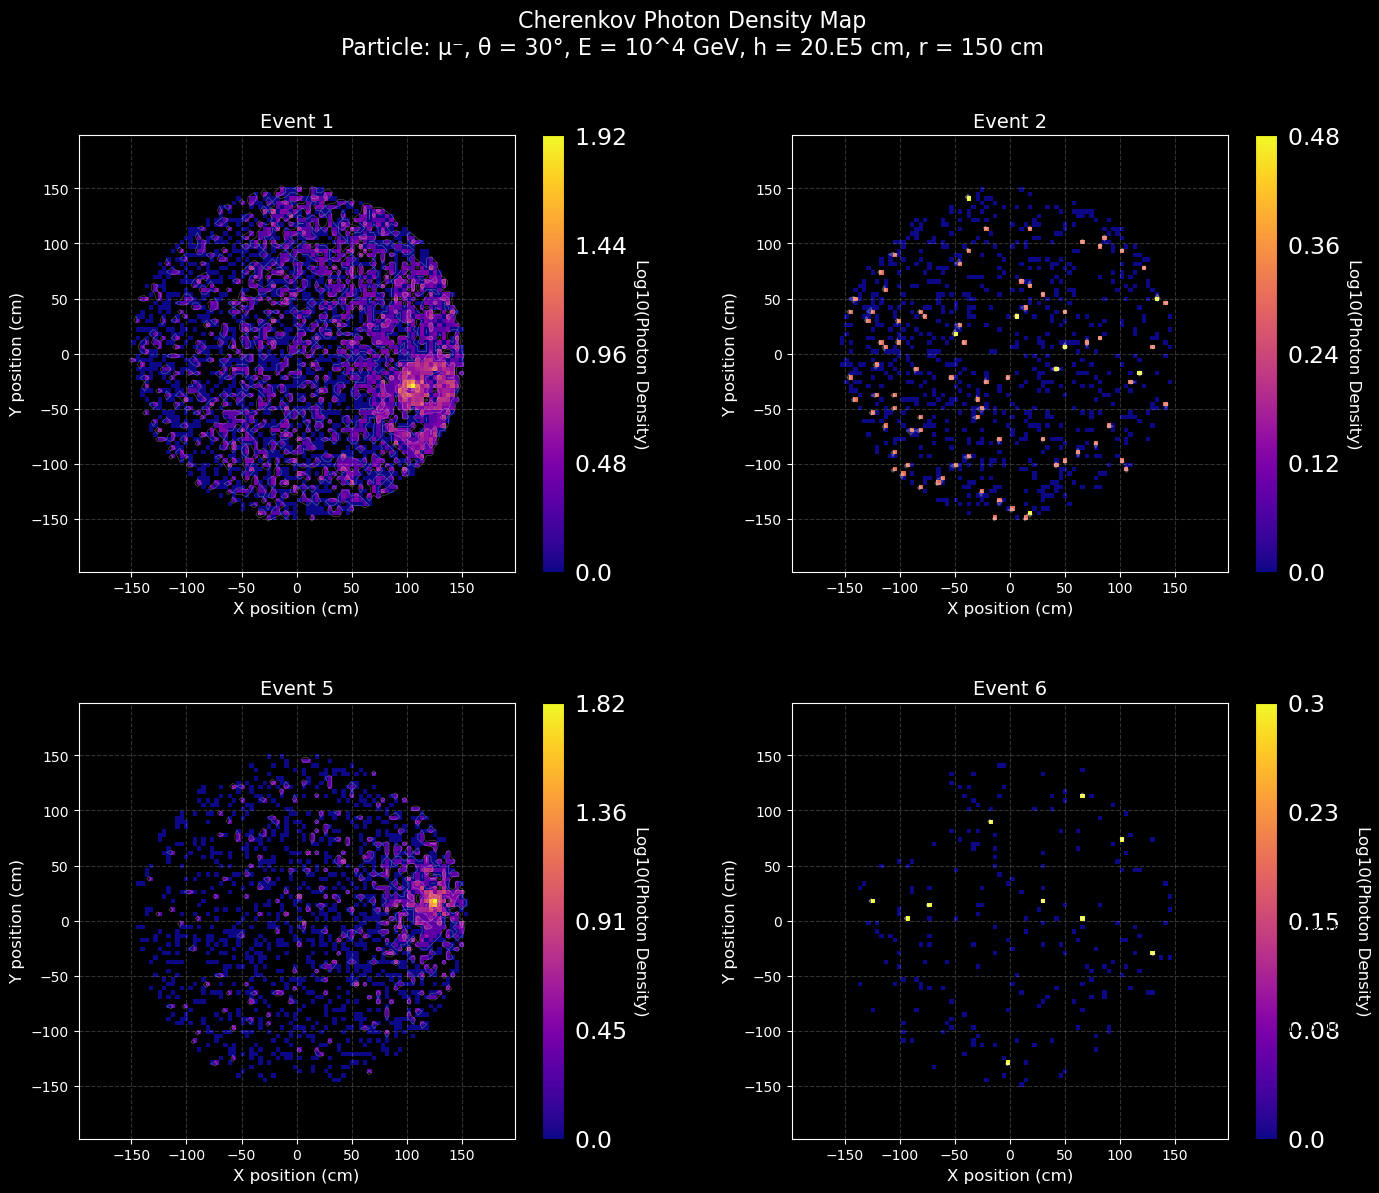

In [2]:

# Define the parameters
zenith = 30  #  available: 0 20 30 50 70 80 85 88 degrees
E_mag = 4  # available: 1.00E6, 1.00E5, 1.00E4, 1.00E3, 1.00E1 GeV
particle = 6  # 5 is mu+, 6 is mu-
production_height = "20.E5"  # available: 10.E5 20.E5 100.E5 cm
tele_radi = "150"  # telescope radius in cm, available:  1500 15000
ID = [1, 2, 5, 6] 

# Generate file paths
input_files = [
    f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_h{production_height}_r{tele_radi}./out_sib23d-pId{particle}-En1.00E{E_mag}-{zenith}./OUTPUT_1.00E{E_mag}_{particle}_{zenith}._{100+i}/telescope.dat"
    for i in ID
]

# Create the plot
plot_4_events(input_files, particle, zenith, E_mag, production_height, tele_radi, num_bins=100)


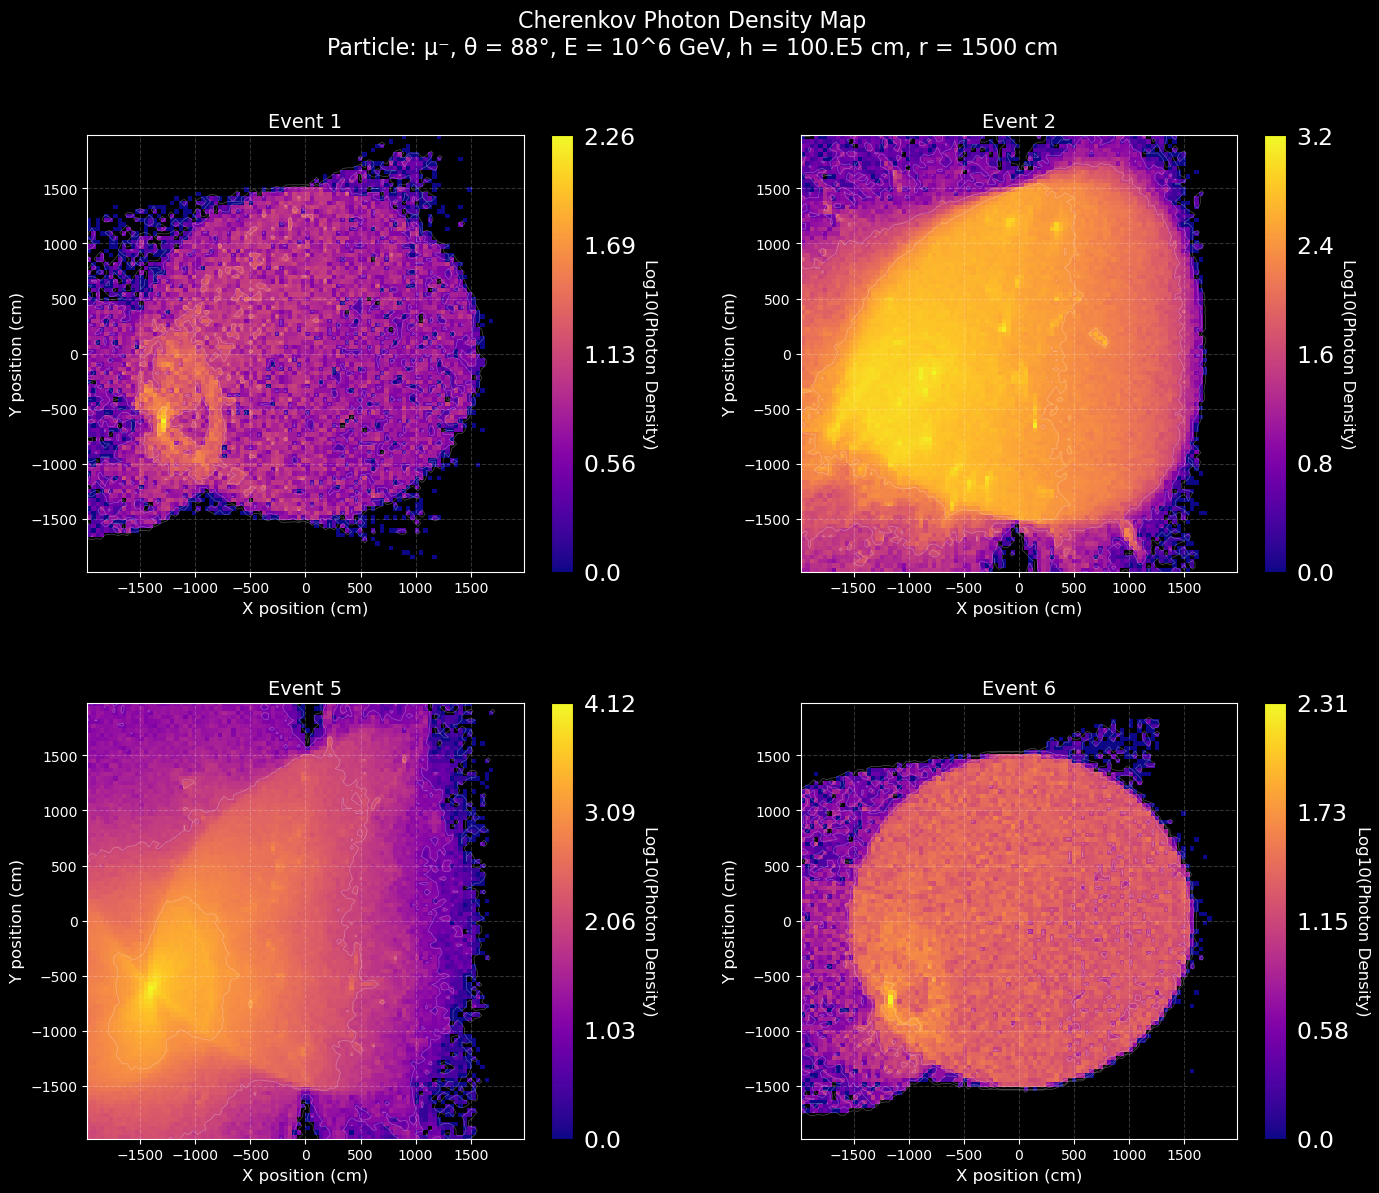

In [18]:
# Define the parameters
zenith = 88  # degrees, available: 0 20 30 50 70 80 85 88
E_mag = 6  # available: 1.00E6, 1.00E5, 1.00E4, 1.00E3, 1.00E1 GeV
particle = 6  # 5 is mu+, 6 is mu-
production_height = "100.E5"  # in cm, available: 20.E5, 10.E5, 100.E5 
tele_radi = "1500"  # telescope radius in cm, available: 150 15000
ID = [1, 2, 5, 6] 

# Generate file paths
input_files = [
    f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_h{production_height}_r{tele_radi}./out_sib23d-pId{particle}-En1.00E{E_mag}-{zenith}./OUTPUT_1.00E{E_mag}_{particle}_{zenith}._{100+i}/telescope.dat"
    for i in ID
]

# Create the plot
plot_4_events(input_files, particle, zenith, E_mag, production_height, tele_radi, num_bins=100)

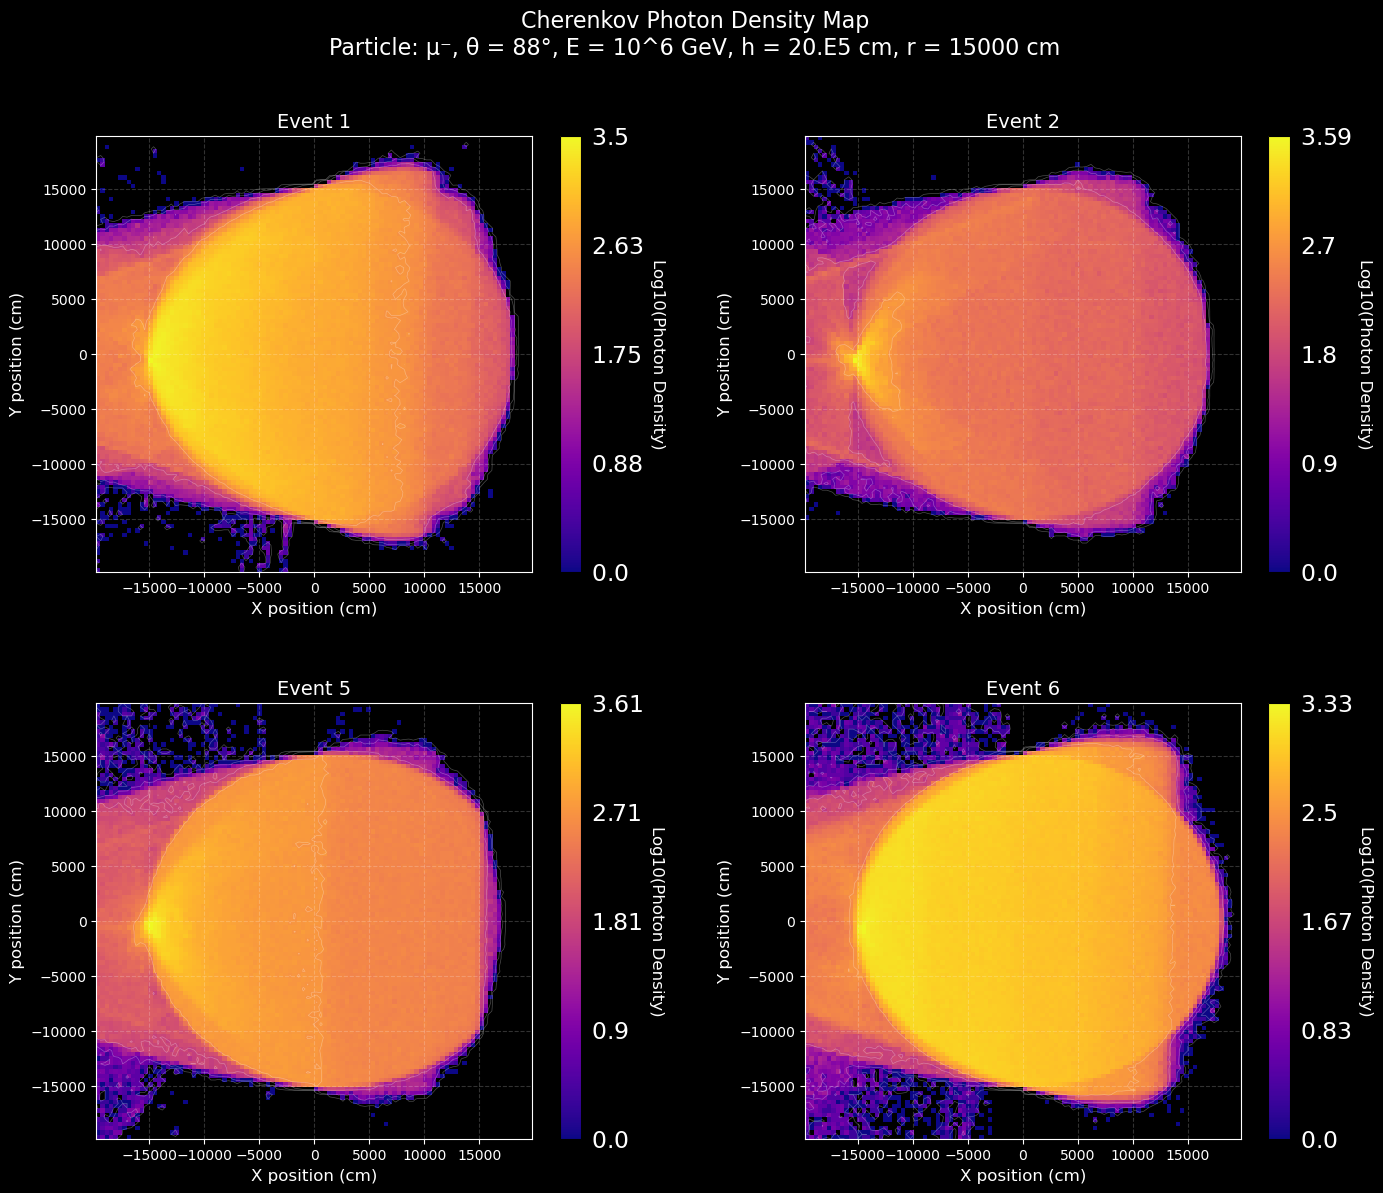

In [13]:
# Define the parameters
zenith = 88  # degrees, available: 0 20 30 50 70 80 85 88
E_mag = 6  # available: 1.00E6, 1.00E5, 1.00E4, 1.00E3, 1.00E1 GeV
particle = 6  # 5 is mu+, 6 is mu-
production_height = "20.E5"  # in cm, available: 20.E5, 10.E5, 100.E5 
tele_radi = "15000"  # telescope radius in cm, available: 150 15000
ID = [1, 2, 5, 6] 

# Generate file paths
input_files = [
    f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_h{production_height}_r{tele_radi}./out_sib23d-pId{particle}-En1.00E{E_mag}-{zenith}./OUTPUT_1.00E{E_mag}_{particle}_{zenith}._{100+i}/telescope.dat"
    for i in ID
]

# Create the plot
plot_4_events(input_files, particle, zenith, E_mag, production_height, tele_radi, num_bins=100)

In [14]:
import plotly.graph_objects as go
from eventio import IACTFile

# Specify input file and event number
file = input_files[3]
event_number = 0

# Open the IACT file
with IACTFile(file) as f:
    # Iterate to the desired event
    it = iter(f)
    event = next(it)
    for i in range(event_number):
        event = next(it)

    # Get observation level
    obslevel = event.header["observation_height"][0]

    # Initialize lists to store data
    x, y, z = [], [], []

    # Iterate over telescope positions and photon bunches
    for pos, b in zip(f.telescope_positions, event.photon_bunches.values()):
        # Calculate x, y coordinates
        cz = 1 - (b['cx']**2 + b['cy']**2)
        x_bunch = b['x'] + ((b['zem'] - obslevel) / cz) * b['cx']
        y_bunch = b['y'] + ((b['zem'] - obslevel) / cz) * b['cy']

        # Adjust x, y coordinates based on telescope position
        x_bunch -= pos[0]
        y_bunch -= pos[1]

        # Append data to lists
        x.extend(x_bunch / 1e5)
        y.extend(y_bunch / 1e5)
        z.extend(b['zem'] / 1e5)

    # Create a 3D scatter plot using Plotly
    fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=3, color='black', opacity=0.2))])
    fig.update_layout(
        scene = dict(
            xaxis_title='x / km',
            yaxis_title='y / km',
            zaxis_title='z / km'
        ),
        width=800,
        height=800
    )
    fig.update_layout(scene_camera=dict(eye=dict(x=1.25, y=1.25, z=0.5)))

# Display the plot
fig.show()


KeyboardInterrupt: 

In [5]:
from eventio import IACTFile
# Define the parameters
zenith = 30  #  available: 0 30 60 88 degrees
E_mag = 6  # available: 1.00E6, 1.00E5, 1.00E4, 1.00E3, 1.00E1 GeV
particle = 6  # 5 is mu+, 6 is mu-
production_height = "20.E5"  # available: 10.E5 20.E5 cm
tele_radi = "1500"  # telescope radius in cm, available:  1500 cm
ID = [1, 2, 3, 4] 
input_files = [
        f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_h{production_height}_r{tele_radi}./out_sib23d-pId{particle}-En1.00E{E_mag}-{zenith}./OUTPUT_1.00E{E_mag}_{particle}_{zenith}._{100+i}/telescope.dat"
        for i in ID
    ]
event = 1
with IACTFile(input_files[0]) as f:
    it = iter(f)
    event = next(it)
    obslevel = event.header["observation_height"][0]

    for pos, b in zip(f.telescope_positions, event.photon_bunches.values()):
        cz = 1 - (b['cx']**2 + b['cy']**2)
        x = b['x'] + ((b['zem'] - obslevel) / cz) * b['cx']
        y = b['y'] + ((b['zem'] - obslevel) / cz) * b['cy']

        x -= pos[0]
        y -= pos[1]
